#Importing the Necessary Libraries

In [ ]:
!pip install keras_preprocessing
!pip install ktrain
!pip install scikit-optimize
import nltk
import pandas as pd
import numpy as np
import joblib
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from skopt import BayesSearchCV
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Activation, Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Flatten, GRU, Conv1D, MaxPooling1D, Bidirectional
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import Word
from wordcloud import WordCloud
from wordcloud import WordCloud,ImageColorGenerator
import ktrain
from ktrain import text

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading the Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Dataset/Final_Spam.csv', encoding='utf-8')
df.head(5)

,Spam,Text
0,Not-Spam,Ya but it cant display internal subs so i gott...
1,Spam,Panasonic & BluetoothHdset FREE. Nokia FREE. M...
2,Not-Spam,this is getting better and better you know NU...
3,Not-Spam,i can t believe i actually read a laugh out lo...
4,Not-Spam,She.s fine. I have had difficulties with her p...


#Exploratory Data Analysis(EDA)

In [ ]:
df.shape

(8571, 2)

In [ ]:
df.describe().T

,count,unique,top,freq
Spam,8571,2,Not-Spam,7325
Text,8570,8040,"Sorry, I'll call later",30


In [ ]:
df['Spam'].value_counts()

Not-Spam    7325
Spam        1246
Name: Spam, dtype: int64

In [ ]:
df.isna().sum()

Spam    0
Text    1
dtype: int64

In [ ]:
df['Text']=df['Text'].fillna("")
df.isna().sum()

Spam    0
Text    0
dtype: int64

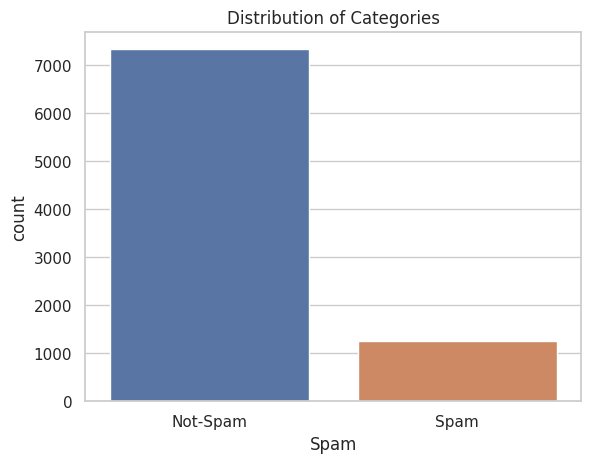

In [ ]:
sns.set_theme(style="whitegrid")
sns.countplot(x=df["Spam"])
plt.title('Distribution of Categories')
plt.show()

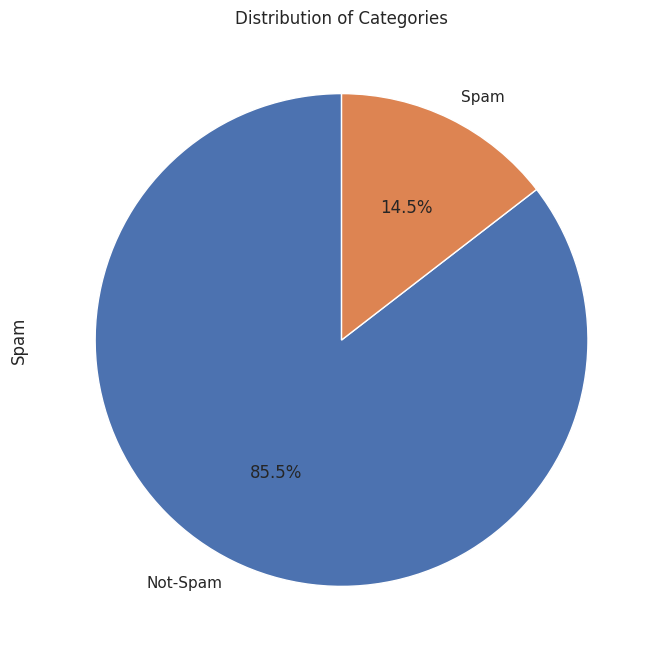

In [ ]:
plt.figure(figsize=(8, 8))
df['Spam'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, explode=[0.0] * len(df['Spam'].unique()))
plt.title('Distribution of Categories')
plt.show()

In [ ]:
df['length'] = df.Text.str.split().apply(len)
df = df[df['length'] <= 3200].copy()

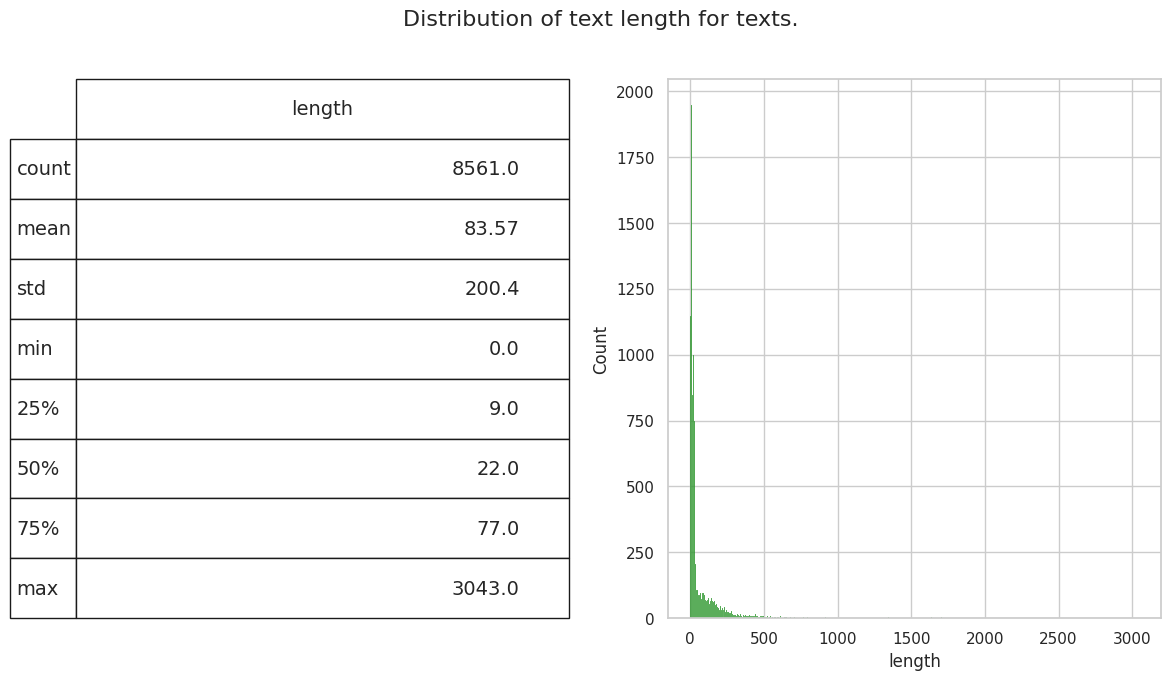

In [ ]:
fig = plt.figure(figsize=(14,7))
ax1 = fig.add_subplot(122)
sns.histplot(df['length'], ax=ax1,color='green')
describe = df.length.describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for texts.', fontsize=16)

plt.show()

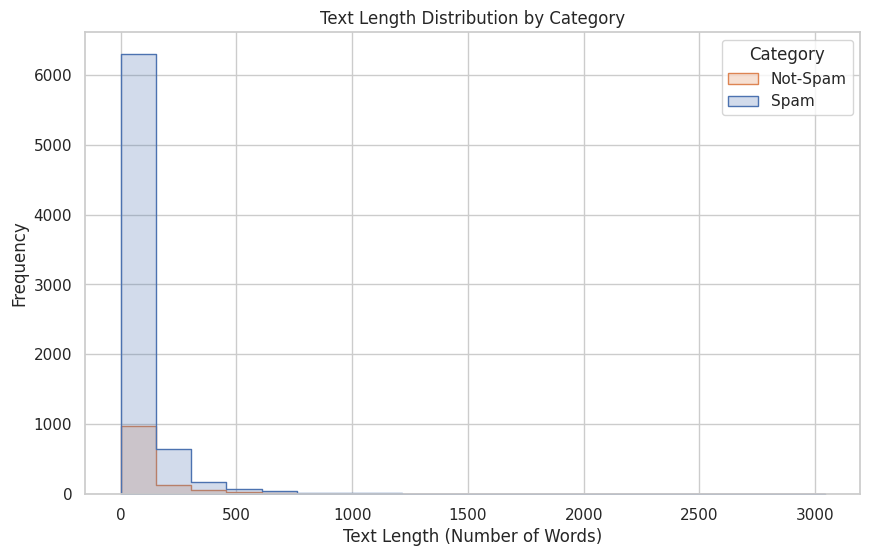

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='length', hue='Spam', bins=20, element='step')
plt.title("Text Length Distribution by Category")
plt.xlabel("Text Length (Number of Words)")
plt.ylabel("Frequency")

unique_category = df['Spam'].unique()
plt.legend(title="Category", labels=unique_category)

plt.show()

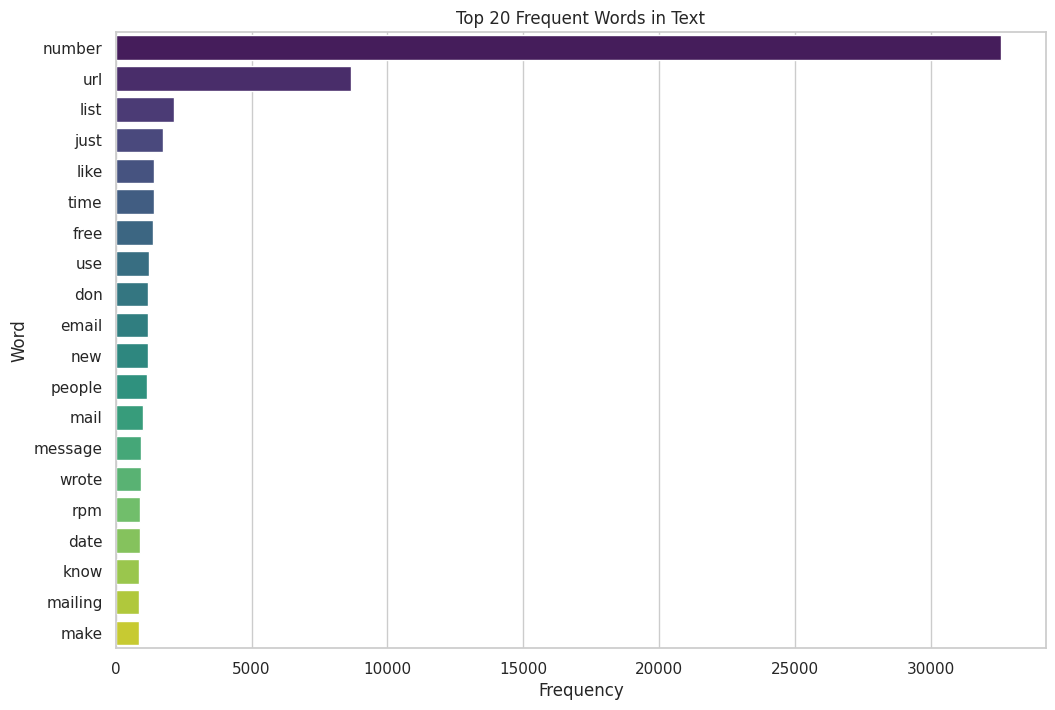

In [ ]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['Text'])

word_freq = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names_out())
top_words = word_freq.transpose().sort_values(0, ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_words[0], y=top_words.index, palette="viridis")
plt.title('Top 20 Frequent Words in Text')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

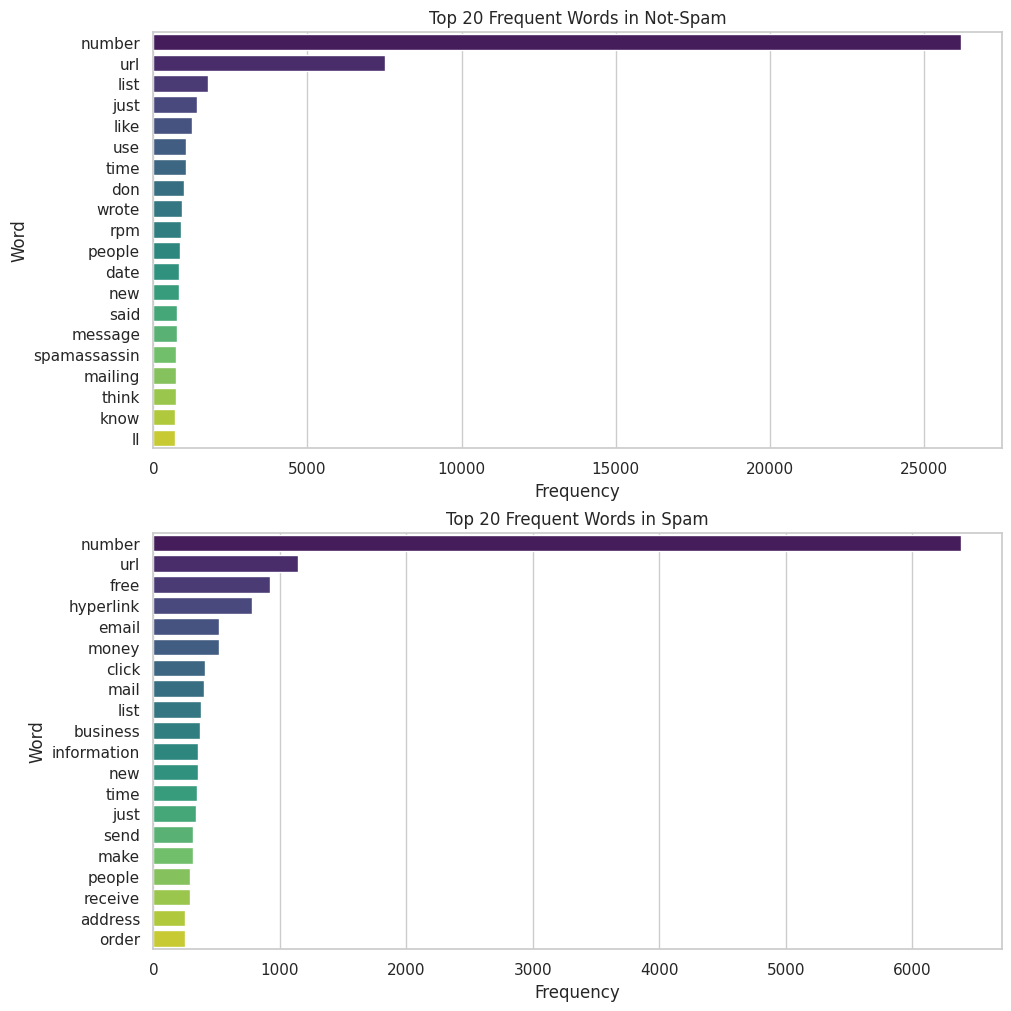

In [ ]:
fig, axes = plt.subplots(nrows=len(df['Spam'].unique()), ncols=1, figsize=(10, 10), constrained_layout=True)

for ax, category in zip(axes, df['Spam'].unique()):
    subset_df = df[df['Spam'] == category]

    X = vectorizer.fit_transform(subset_df['Text'])
    word_freq = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names_out())
    top_words = word_freq.transpose().sort_values(0, ascending=False).head(20)

    sns.barplot(x=top_words[0], y=top_words.index, palette="viridis", ax=ax)
    ax.set_title(f'Top 20 Frequent Words in {category}')
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Word')

plt.show()

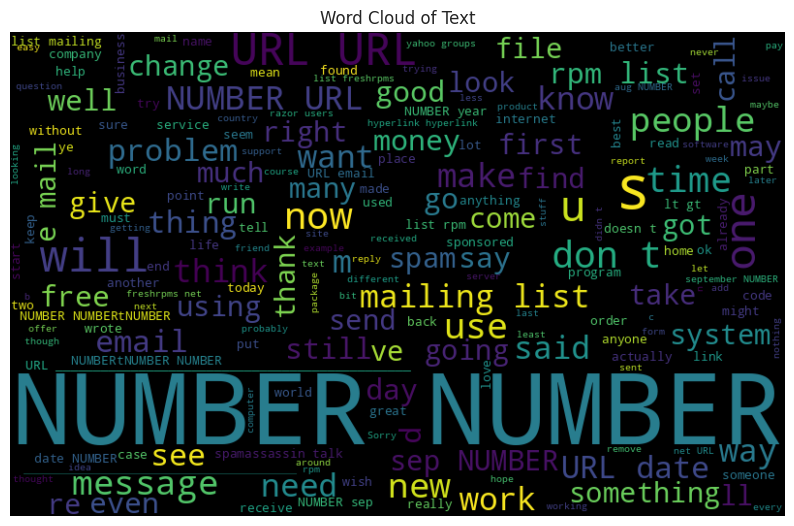

In [ ]:
normal_words =' '.join([text for text in df['Text']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Word Cloud of Text")
plt.axis('off')
plt.show()

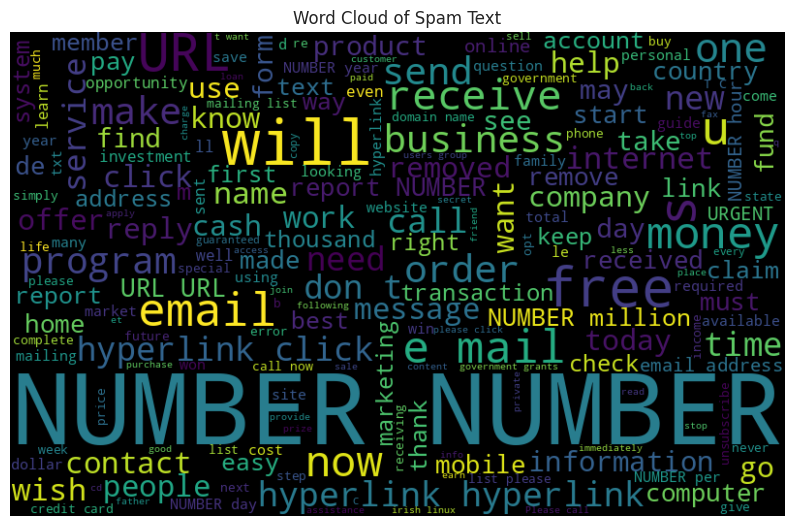

In [ ]:
normal_words =' '.join([text for text in df['Text'][df['Spam'] == 'Spam']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Word Cloud of Spam Text")
plt.axis('off')
plt.show()

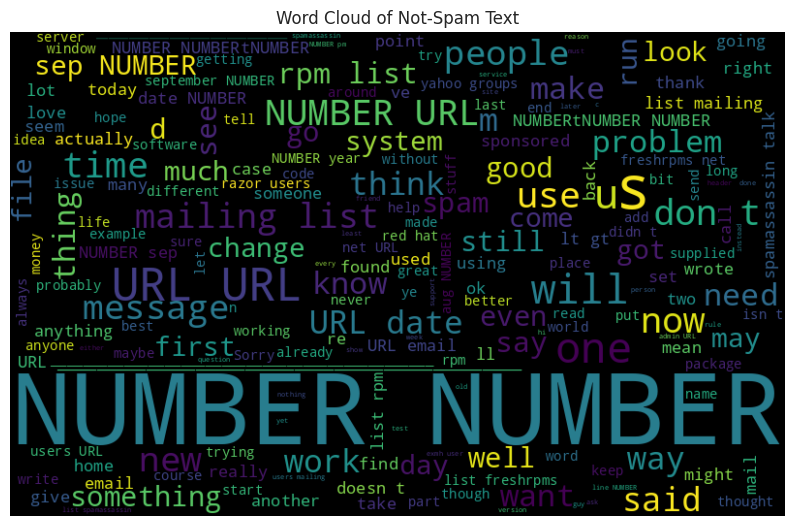

In [ ]:
normal_words =' '.join([text for text in df['Text'][df['Spam'] == 'Not-Spam']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Word Cloud of Not-Spam Text")
plt.axis('off')
plt.show()

#Text Cleaning and Preprocessing

In [ ]:
def clean_text(text):
    text = text.lower()
    text = text.replace(r'^.+@[^\.].*\.[a-z]{2,}$', 'emailaddress')
    text = text.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$', 'webaddress')
    text = text.replace(r'£|\$', 'moneysymb')
    text = text.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$', 'phonenumbr')
    text = text.replace(r'\d+(\.\d+)?', 'numbr')
    text = text.replace(r'[^\w\d\s]', ' ')
    text = text.replace(r'\s+', ' ')
    text = text.replace(r'^\s+|\s+?$', '')

    stops = set(stopwords.words('english'))
    text = ' '.join(term for term in text.split() if term not in stops)

    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])

    return text

df['text'] = df['Text'].apply(clean_text)

In [ ]:
df.head(5)

,Spam,Text,text
0,Not-Spam,Ya but it cant display internal subs so i gott...,ya cant display internal sub gotta extract
1,Spam,Panasonic & BluetoothHdset FREE. Nokia FREE. M...,panasonic & bluetoothhdset free. nokia free. m...
2,Not-Spam,this is getting better and better you know NU...,getting better better know numberk utter shite...
3,Not-Spam,i can t believe i actually read a laugh out lo...,believe actually read laugh loud funny profile...
4,Not-Spam,She.s fine. I have had difficulties with her p...,she.s fine. difficulty phone. work mine. pls s...


#Machine Learning Models

##Text Data Splitting and TF-IDF Vectorization

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df["text"], df["Spam"], test_size=0.20, random_state=42)

tfidf = TfidfVectorizer(ngram_range=(1, 2), norm='l2', sublinear_tf=True)

x_train_tfidf = tfidf.fit_transform(x_train)

x_test_tfidf = tfidf.transform(x_test)

print(x_train_tfidf.shape, x_test_tfidf.shape, y_train.shape, y_test.shape)

(6856, 228103) (1715, 228103) (6856,) (1715,)


In [ ]:
joblib.dump(tfidf, 'tfidf.pkl')
#model = joblib.load('tfidf.pkl')

['tfidf.pkl']

##Hyperparameter Tuning and Model Evaluation for Logistic Regression

In [ ]:
def objective(params):
    lr = LogisticRegression(C=params['C'],
          max_iter=params['max_iter'],
          n_jobs=-1)
    score = cross_val_score(lr, x_train_tfidf, y_train, cv=3, scoring='accuracy').mean()
    return -score

search_space = {
    'C': (1e-6, 1e+6, 'log-uniform'),
    'max_iter': (200, 1000)
}

bayes_search = BayesSearchCV(
    LogisticRegression(),
    search_space,
    n_iter=20,
    cv=5,
    n_jobs=-1
)

bayes_search.fit(x_train_tfidf, y_train)

BayesSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20, n_jobs=-1,
              search_spaces={'C': (1e-06, 1000000.0, 'log-uniform'),
                             'max_iter': (200, 1000)})

In [ ]:
print("Best hyperparameters:", bayes_search.best_params_)

best_lr_model = bayes_search.best_estimator_

y_pred = best_lr_model.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred) * 100
print("Accuracy: {:.2f}%".format(accuracy))

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Best hyperparameters: OrderedDict([('C', 2264.3424879006393), ('max_iter', 1000)])
Accuracy: 98.32%
Classification Report:
               precision    recall  f1-score   support

    Not-Spam       0.99      1.00      0.99      1824
        Spam       0.97      0.92      0.94       318

    accuracy                           0.98      2142
   macro avg       0.98      0.96      0.97      2142
weighted avg       0.98      0.98      0.98      2142



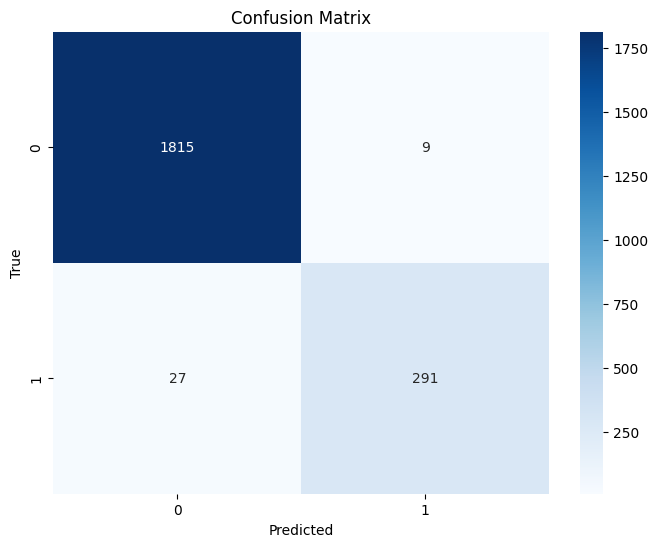

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
scores = cross_val_score(best_lr_model, x_train_tfidf,y_train, cv=5)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test,y_pred)*100))
print ("Cross-validated scores:", scores)

Accuracy: 98.32%
Cross-validated scores: [0.97743191 0.98132296 0.98054475 0.97821012 0.98286604]


In [ ]:
m = tfidf.transform(["free entry in a 2 weekly comp win fa cup final tkt numbrst may numbr text fa numbr receiv entri question std txt rate c appli numbrovernumbr"])
y_pred = best_lr_model.predict(m)
print(y_pred)

['Spam']


##Model Training and Evaluation for Linear Support Vector Classifier

In [ ]:
svc = LinearSVC()
svc.fit(x_train_tfidf, y_train)

LinearSVC()

In [ ]:
y_pred2 = svc.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred2) * 100
print("Accuracy: {:.2f}%".format(accuracy))

report = classification_report(y_test, y_pred2)
print("Classification Report:\n", report)

Accuracy: 99.02%
Classification Report:
               precision    recall  f1-score   support

    Not-Spam       0.99      1.00      0.99      1824
        Spam       0.98      0.96      0.97       318

    accuracy                           0.99      2142
   macro avg       0.98      0.98      0.98      2142
weighted avg       0.99      0.99      0.99      2142



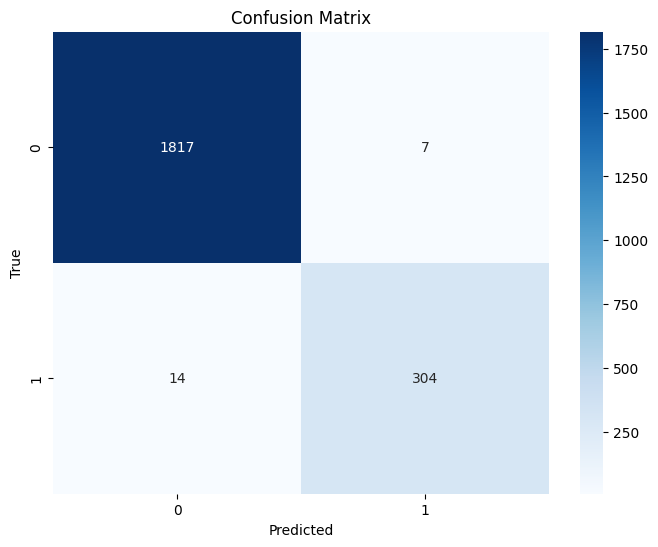

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
scores = cross_val_score(svc, x_train_tfidf,y_train, cv=5)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test,y_pred2)*100))
print ("Cross-validated scores:", scores)

Accuracy: 99.02%
Cross-validated scores: [0.97587549 0.9766537  0.97198444 0.97120623 0.9758567 ]


In [ ]:
m = tfidf.transform(["free entry in a 2 weekly comp win fa cup final tkt numbrst may numbr text fa numbr receiv entri question std txt rate c appli numbrovernumbr"])
y_pred = svc.predict(m)
print(y_pred)

['Spam']


In [ ]:
joblib.dump(svc, 'spam_svm.pkl')
#model = joblib.load('spam_svm.pkl')

['spam_svm.pkl']

##Hyperparameter Tuning and Model Evaluation for Multinomial Naive Bayes (MNB)

In [ ]:
def objective(params):
    mnb = MultinomialNB(alpha=params['alpha'])
    score = cross_val_score(mnb, x_train_tfidf, y_train, cv=3, scoring='accuracy').mean()
    return -score

search_space = {
    'alpha': (1e-6, 1e+6, 'log-uniform')
}

bayes_search = BayesSearchCV(
    MultinomialNB(),
    search_space,
    n_iter=20,
    cv=5,
    n_jobs=-1
)

bayes_search.fit(x_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=MultinomialNB(), n_iter=20, n_jobs=-1,
              search_spaces={'alpha': (1e-06, 1000000.0, 'log-uniform')})

In [ ]:
print("Best hyperparameters:", bayes_search.best_params_)

best_mnb_model = bayes_search.best_estimator_

y_pred3 = best_mnb_model.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred3) * 100
print("Accuracy: {:.2f}%".format(accuracy))

report = classification_report(y_test, y_pred3)
print("Classification Report:\n", report)

Best hyperparameters: OrderedDict([('alpha', 0.11325300281759654)])
Accuracy: 97.61%
Classification Report:
               precision    recall  f1-score   support

    Not-Spam       0.97      1.00      0.99      1471
        Spam       0.99      0.84      0.91       244

    accuracy                           0.98      1715
   macro avg       0.98      0.92      0.95      1715
weighted avg       0.98      0.98      0.98      1715



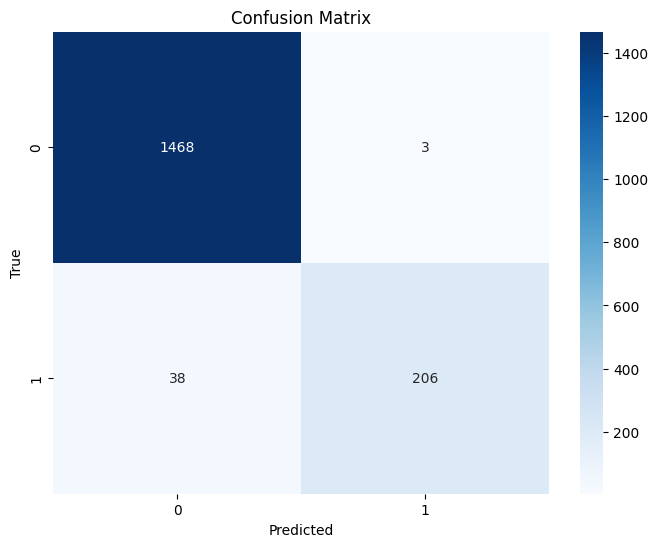

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred3)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
scores = cross_val_score(best_mnb_model, x_train_tfidf, y_train, cv=5)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test,y_pred3)*100))
print("Cross-validated scores:", scores)

Accuracy: 97.61%
Cross-validated scores: [0.9803207  0.98030635 0.98249453 0.9868709  0.9861415 ]


In [ ]:
m = tfidf.transform(["free entry in a 2 weekly comp win fa cup final tkt numbrst may numbr text fa numbr receiv entri question std txt rate c appli numbrovernumbr"])
y_pred = best_mnb_model.predict(m)
print(y_pred)

['Spam']


##Hyperparameter Tuning and Model Evaluation for RandomForestClassifier

In [ ]:
def objective(params):
    rfc = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        random_state=42,
        class_weight=params['class_weight']
    )
    score = cross_val_score(rfc, x_train_tfidf, y_train, cv=3, scoring='accuracy').mean()
    return -score

search_space = {
    'n_estimators': (500, 1000),
    'max_depth': (5, 20),
    'class_weight': (['balanced'])
}

bayes_search = BayesSearchCV(
    RandomForestClassifier(),
    search_space,
    n_iter=20,
    cv=5,
    n_jobs=-1
)

bayes_search.fit(x_train_tfidf, y_train)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


BayesSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20, n_jobs=-1,
              search_spaces={'class_weight': ['balanced'], 'max_depth': (5, 20),
                             'n_estimators': (500, 1000)})

In [ ]:
print("Best hyperparameters:", bayes_search.best_params_)

best_rfc_model = bayes_search.best_estimator_

y_pred4 = best_rfc_model.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred4) * 100
print("RandomForestClassifier Accuracy: {:.2f}%".format(accuracy))

report = classification_report(y_test, y_pred4)
print("RandomForestClassifier Classification Report:\n", report)

Best hyperparameters: OrderedDict([('class_weight', 'balanced'), ('max_depth', 20), ('n_estimators', 501)])
RandomForestClassifier Accuracy: 97.53%
RandomForestClassifier Classification Report:
               precision    recall  f1-score   support

    Not-Spam       0.97      1.00      0.99      1824
        Spam       1.00      0.84      0.91       318

    accuracy                           0.98      2142
   macro avg       0.98      0.92      0.95      2142
weighted avg       0.98      0.98      0.97      2142



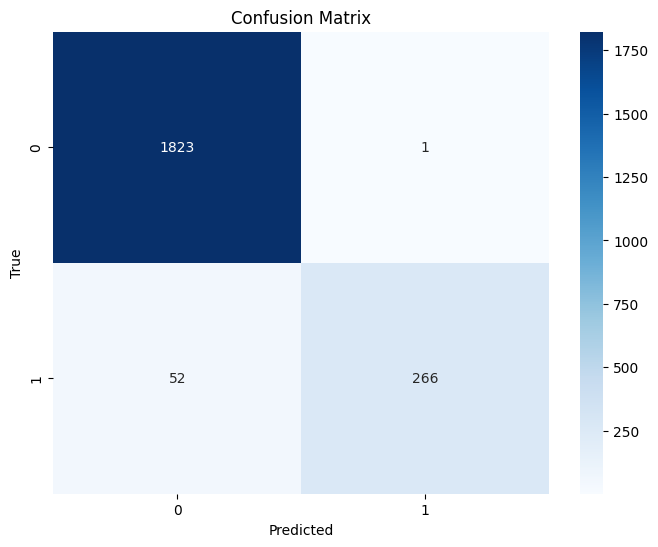

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred4)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
scores = cross_val_score(best_rfc_model, x_train_tfidf,y_train, cv=5)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test,y_pred4)*100))
print("Cross-validated scores:", scores)

Accuracy: 97.53%
Cross-validated scores: [0.97042802 0.97431907 0.97354086 0.96653696 0.9711838 ]


In [ ]:
m = tfidf.transform(["free entry in a 2 weekly comp win fa cup final tkt numbrst may numbr text fa numbr receiv entri question std txt rate c appli numbrovernumbr"])
y_pred = best_rfc_model.predict(m)
print(y_pred)

['Spam']


##Model Training and Evaluation for Gradient Boosting Classifier

In [ ]:
gbc = GradientBoostingClassifier(n_estimators=100, max_features=1.0, max_depth=4, random_state=1, verbose=1)
gbc.fit(x_train_tfidf, y_train)

y_pred5 = gbc.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred5) * 100
print("Accuracy: {:.2f}%".format(accuracy))

report = classification_report(y_test, y_pred5)
print("Classification Report:\n", report)

      Iter       Train Loss   Remaining Time 
         1           0.7019            2.66m
         2           0.6268            2.55m
         3           0.5735            2.45m
         4           0.5302            2.27m
         5           0.4937            2.28m
         6           0.4634            2.43m
         7           0.4385            2.57m
         8           0.4149            2.66m
         9           0.3945            2.60m
        10           0.3768            2.55m
        20           0.2673            1.69m
        30           0.2110            1.29m
        40           0.1796           58.79s
        50           0.1595           47.24s
        60           0.1414           35.55s
        70           0.1199           26.19s
        80           0.1113           16.71s
        90           0.1030            8.18s
       100           0.0976            0.00s
Accuracy: 97.57%
Classification Report:
               precision    recall  f1-score   support

   

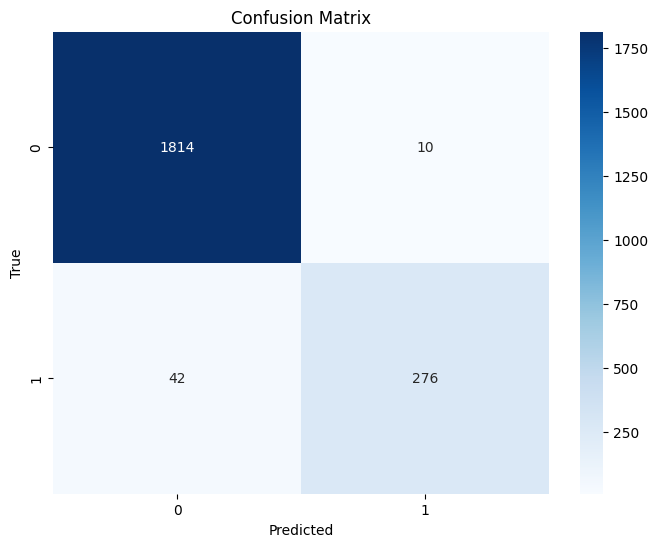

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred5)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
scores = cross_val_score(gbc, x_train_tfidf,y_train, cv=5)
print("Accuracy: {:.2f}%".format(accuracy_score(y_test,y_pred5)*100))
print("Cross-validated scores:", scores)

      Iter       Train Loss   Remaining Time 
         1           0.6992            2.90m
         2           0.6260            2.87m
         3           0.5715            2.84m
         4           0.5259            3.14m
         5           0.4902            3.53m
         6           0.4601            3.53m
         7           0.4334            3.37m
         8           0.4095            3.26m
         9           0.3892            3.16m
        10           0.3706            3.07m
        20           0.2620            2.80m
        30           0.2064            2.49m
        40           0.1751            2.10m
        50           0.1533            1.73m
        60           0.1280            1.39m
        70           0.1160            1.05m
        80           0.1076           41.53s
        90           0.1002           20.82s
       100           0.0949            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.7019            2.89m
        

In [ ]:
m = tfidf.transform(["free entry in a 2 weekly comp win fa cup final tkt numbrst may numbr text fa numbr receiv entri question std txt rate c appli numbrovernumbr"])
y_pred = gbc.predict(m)
print(y_pred)

['Spam']


##Model Training and Evaluation for XGBoost Classifier

In [ ]:
le = LabelEncoder()
y_train_binary = le.fit_transform(y_train)
y_test_binary = le.transform(y_test)

xgb = XGBClassifier(n_estimators=100, max_depth=4, random_state=1)
xgb.fit(x_train_tfidf, y_train_binary)

y_pred6 = xgb.predict(x_test_tfidf)

accuracy = accuracy_score(y_test_binary, y_pred6) * 100
print("Accuracy: {:.2f}%".format(accuracy))

report = classification_report(y_test_binary, y_pred6)
print("Classification Report:\n", report)

Accuracy: 98.27%
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1824
           1       0.98      0.91      0.94       318

    accuracy                           0.98      2142
   macro avg       0.98      0.95      0.96      2142
weighted avg       0.98      0.98      0.98      2142



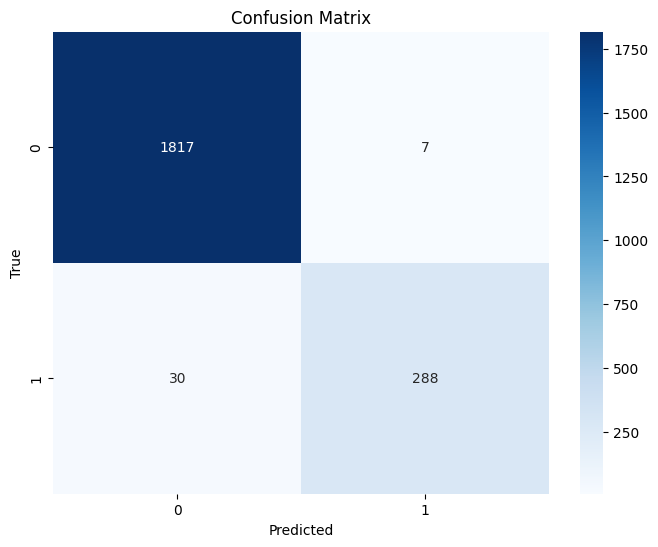

In [ ]:
conf_matrix = confusion_matrix(y_test_binary, y_pred6)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
scores = cross_val_score(xgb, x_train_tfidf, y_train_binary, cv=5)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test_binary,y_pred6)*100))
print("Cross-validated scores:", scores)

Accuracy: 98.27%
Cross-validated scores: [0.97743191 0.98754864 0.98287938 0.97509728 0.98208723]


In [ ]:
m = tfidf.transform(["free entry in a 2 weekly comp win fa cup final tkt numbrst may numbr text fa numbr receiv entri question std txt rate c appli numbrovernumbr"])
y_pred = xgb.predict(m)
print(y_pred)

[1]


##Ensemble Model Training and Evaluation for Voting Classifier

In [ ]:
mnb = MultinomialNB(alpha= 0.12683542101792877)
rfc= RandomForestClassifier(n_estimators=832, max_depth=20, class_weight= 'balanced' ,random_state=42)
lr = LogisticRegression(C = 3427.09, max_iter = 1000, n_jobs=-1)

ec=VotingClassifier(estimators=[('Multinominal NB', mnb), ('Random Forest', rfc),('Logistic Regression',lr)], voting='soft', weights=[1,1,1])
ec.fit(x_train_tfidf,y_train)

y_pred7 = ec.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred7) * 100
print("Accuracy: {:.2f}%".format(accuracy))

report = classification_report(y_test, y_pred7)
print("Classification Report:\n", report)

Accuracy: 98.41%
Classification Report:
               precision    recall  f1-score   support

    Not-Spam       0.98      1.00      0.99      1824
        Spam       0.99      0.90      0.94       318

    accuracy                           0.98      2142
   macro avg       0.99      0.95      0.97      2142
weighted avg       0.98      0.98      0.98      2142



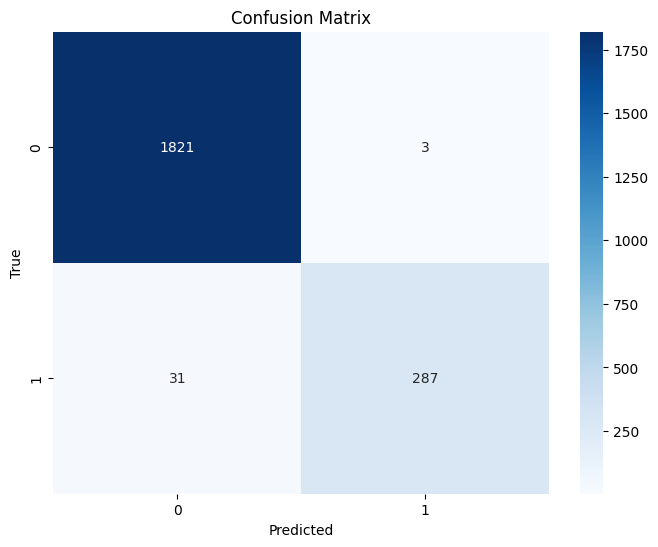

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred7)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
scores = cross_val_score(ec, x_train_tfidf, y_train, cv=5)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test,y_pred7)*100))
print("Cross-validated scores:", scores)

Accuracy: 98.41%
Cross-validated scores: [0.98054475 0.98754864 0.98210117 0.98132296 0.98208723]


In [ ]:
m = tfidf.transform(["free entry in a 2 weekly comp win fa cup final tkt numbrst may numbr text fa numbr receiv entri question std txt rate c appli numbrovernumbr"])
y_pred = ec.predict(m)
print(y_pred)

['Spam']


In [ ]:
joblib.dump(svc, 'spam_ensemble.pkl')
#model = joblib.load('spam_ensemble.pkl')

['spam_ensemble.pkl']

##Model Training and Evaluation for AdaBoost with RandomForestClassifier Base Estimator

In [ ]:
rfc= RandomForestClassifier(n_estimators=832, max_depth=4, class_weight= 'balanced' ,random_state=42)

abc= AdaBoostClassifier(estimator=rfc, learning_rate=0.2, n_estimators=100)
abc.fit(x_train_tfidf, y_train)

y_pred8= abc.predict(x_test_tfidf)

accuracy = accuracy_score(y_test, y_pred8) * 100
print("Accuracy: {:.2f}%".format(accuracy))

report = classification_report(y_test, y_pred8)
print("Classification Report:\n", report)

Accuracy: 98.55%
Classification Report:
               precision    recall  f1-score   support

    Not-Spam       0.99      1.00      0.99      1824
        Spam       0.99      0.92      0.95       318

    accuracy                           0.99      2142
   macro avg       0.99      0.96      0.97      2142
weighted avg       0.99      0.99      0.99      2142



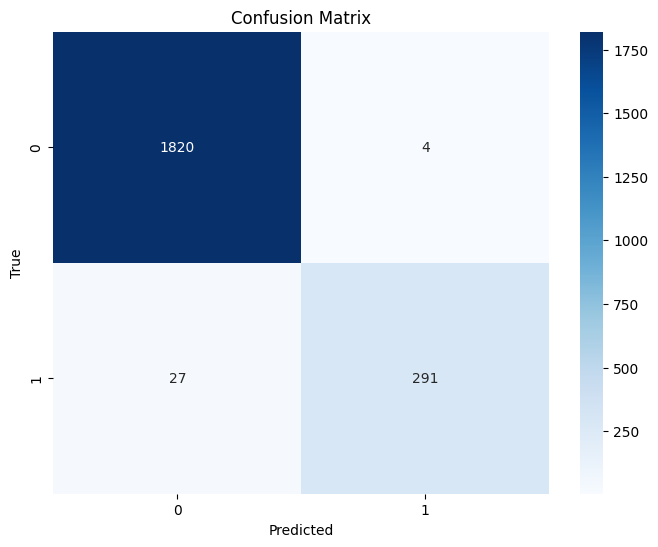

In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred8)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
scores = cross_val_score(abc, x_train_tfidf, y_train, cv=5)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test,y_pred8)*100))
print("Cross-validated scores:", scores)

Accuracy: 98.55%
Cross-validated scores: [0.98132296 0.98988327 0.97976654 0.97976654 0.97819315]


In [ ]:
m = tfidf.transform(["free entry in a 2 weekly comp win fa cup final tkt numbrst may numbr text fa numbr receiv entri question std txt rate c appli numbrovernumbr"])
y_pred = abc.predict(m)
print(y_pred)

#Deep Learning Models

##Text Tokenization and Padding for Deep Learning Models

In [ ]:
label_encoder = LabelEncoder()
df['Spam'] = label_encoder.fit_transform(df['Spam'])

In [ ]:
X = df['Text']
y = df['Spam']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

34019


In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
max_length = 120
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

##LSTM Model Training and Evaluation

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model_lstm.add(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
model_lstm.add(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
model_lstm.add(LSTM(32, return_sequences=True))
model_lstm.add(LSTM(16, return_sequences=True))
model_lstm.add(Dropout(0.3))
model_lstm.add(Flatten())
model_lstm.add(Dense(128, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 128)          4354432   
                                                                 
 lstm_5 (LSTM)               (None, 120, 128)          131584    
                                                                 
 lstm_6 (LSTM)               (None, 120, 64)           49408     
                                                                 
 lstm_7 (LSTM)               (None, 120, 32)           12416     
                                                                 
 lstm_8 (LSTM)               (None, 120, 16)           3136      
                                                                 
 dropout_4 (Dropout)         (None, 120, 16)           0         
                                                                 
 flatten_2 (Flatten)         (None, 1920)             

In [ ]:
hist_lstm= model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

Epoch 1/5
54/54 [==============================] - 120s 2s/step - loss: 0.3434 - accuracy: 0.8703 - val_loss: 0.1438 - val_accuracy: 0.9574
Epoch 2/5
54/54 [==============================] - 103s 2s/step - loss: 0.0826 - accuracy: 0.9787 - val_loss: 0.0634 - val_accuracy: 0.9813
Epoch 3/5
54/54 [==============================] - 105s 2s/step - loss: 0.0380 - accuracy: 0.9898 - val_loss: 0.0623 - val_accuracy: 0.9854
Epoch 4/5
54/54 [==============================] - 104s 2s/step - loss: 0.0203 - accuracy: 0.9947 - val_loss: 0.0679 - val_accuracy: 0.9837
Epoch 5/5
54/54 [==============================] - 104s 2s/step - loss: 0.0128 - accuracy: 0.9977 - val_loss: 0.0819 - val_accuracy: 0.9854


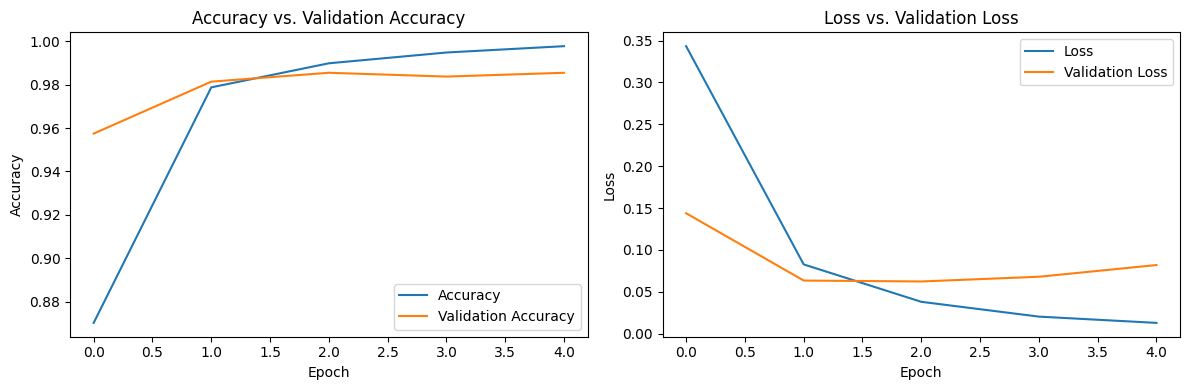

In [ ]:
accuracy = hist_lstm.history['accuracy']
val_accuracy = hist_lstm.history['val_accuracy']
loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
hist_=pd.DataFrame(hist_lstm.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.343398,0.870333,0.143785,0.957434
1,0.082633,0.978705,0.063359,0.981341
2,0.037957,0.989790,0.062259,0.985423
3,0.020268,0.994749,0.067894,0.983673
4,0.012774,0.997666,0.081875,0.985423


In [ ]:
loss, accuracy = model_lstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

54/54 [==============================] - 10s 184ms/step - loss: 0.0819 - accuracy: 0.9854
Test Loss: 0.0819
Test Accuracy: 98.54%


In [ ]:
class_names = label_encoder.classes_

y_test_original = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_lstm.predict(X_test), axis=1)

report = classification_report(y_test_original, y_pred, target_names=class_names)
print('Classification Report:\n', report)

54/54 [==============================] - 15s 141ms/step
Classification Report:
               precision    recall  f1-score   support

    Not-Spam       0.99      1.00      0.99      1471
        Spam       0.98      0.92      0.95       244

    accuracy                           0.99      1715
   macro avg       0.98      0.96      0.97      1715
weighted avg       0.99      0.99      0.99      1715



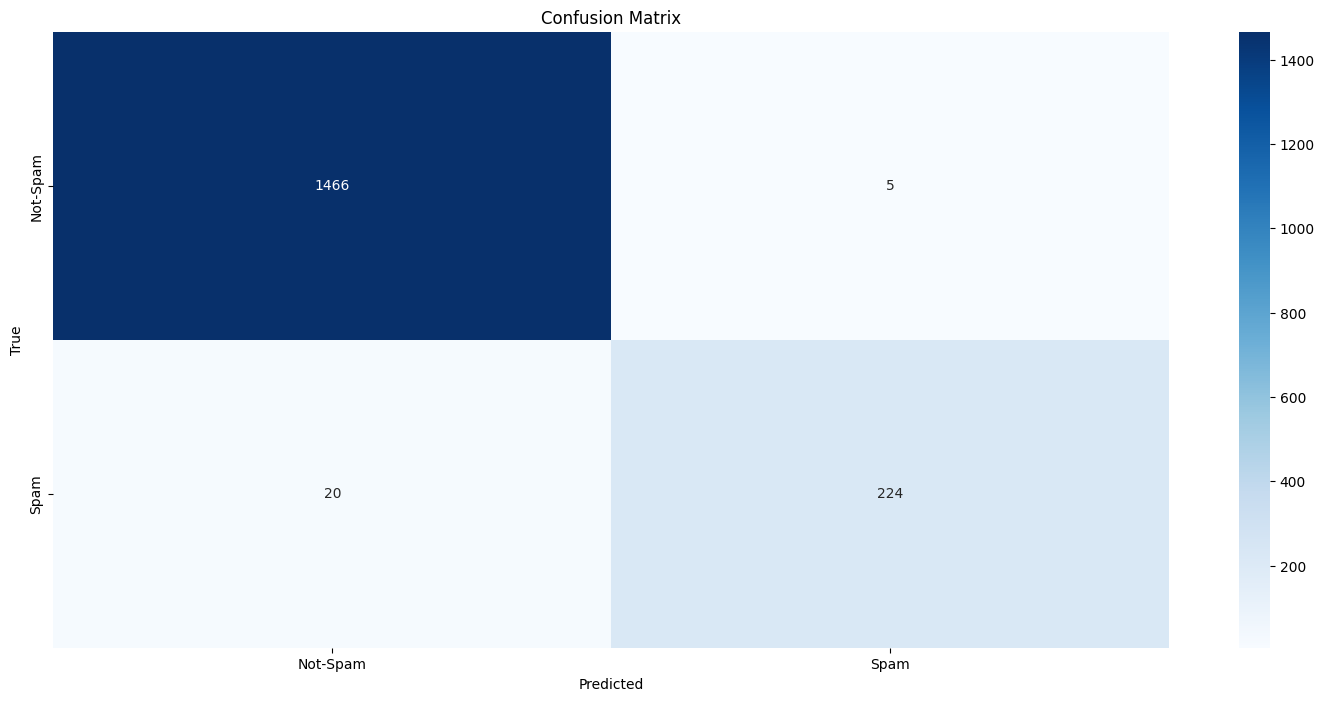

In [ ]:
conf_matrix = confusion_matrix(y_test_original, y_pred)

plt.figure(figsize=(18, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def predict_texts(texts, model, tokenizer, max_length, label_encoder):
    predictions = []

    for text in texts:
        cleaned_text = clean_text(text)
        sequences = tokenizer.texts_to_sequences([cleaned_text])
        padded_sequences = pad_sequences(sequences, maxlen=max_length)

        probabilities = model.predict(padded_sequences)[0]
        predicted_text = label_encoder.inverse_transform([probabilities.argmax()])[0]
        predictions.append((predicted_text, probabilities.max()))

    return predictions

texts = [
    "Congratulations! You've won a luxury vacation for two! 🏖️ Claim your prize now by clicking on the link below and providing your personal information. Don't miss this once-in-a-lifetime opportunity!",
    "I hope this email finds you well. Attached is the report you requested for our upcoming meeting. Please review it at your convenience, and let me know if you have any questions or need further clarification.",
    "Congratulations! You've won a free iPhone. Claim your prize now by clicking the link below!",
    "Earn $1,000 a day from home with our revolutionary work-from-home system.",
    "Reminder: Your dentist appointment is scheduled for 2:00 PM on Thursday, October 18th."
]

predicted_texts = predict_texts( texts, model_lstm, tokenizer, max_length, label_encoder)

for text, (predicted_text, probability) in zip(texts, predicted_texts):
    print(f"Text: '{text}'")
    print(f"Predicted Category: {predicted_text}")
    print(f"Probability of {predicted_text}: {probability:.4f}\n")


1/1 [==============================] - 0s 236ms/step
Text: 'Congratulations! You've won a luxury vacation for two! 🏖️ Claim your prize now by clicking on the link below and providing your personal information. Don't miss this once-in-a-lifetime opportunity!'
Predicted Category: Spam
Probability of Spam: 0.9996

Text: 'I hope this email finds you well. Attached is the report you requested for our upcoming meeting. Please review it at your convenience, and let me know if you have any questions or need further clarification.'
Predicted Category: Not-Spam
Probability of Not-Spam: 0.9993

Text: 'Congratulations! You've won a free iPhone. Claim your prize now by clicking the link below!'
Predicted Category: Spam
Probability of Spam: 0.9451

Text: 'Earn $1,000 a day from home with our revolutionary work-from-home system.'
Predicted Category: Spam
Probability of Spam: 0.9867

Text: 'Reminder: Your dentist appointment is scheduled for 2:00 PM on Thursday, October 18th.'
Predicted Category: Not-

##GRU Model Training and Evaluation

In [ ]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model_gru.add(GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
model_gru.add(GRU(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
model_gru.add(GRU(32, return_sequences=True))
model_gru.add(GRU(16, return_sequences=True))
model_gru.add(Dropout(0.3))
model_gru.add(Flatten())
model_gru.add(Dense(128, activation='relu'))
model_gru.add(Dropout(0.3))
model_gru.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_gru.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_gru.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 128)          4354432   
                                                                 
 gru_4 (GRU)                 (None, 120, 128)          99072     
                                                                 
 gru_5 (GRU)                 (None, 120, 64)           37248     
                                                                 
 gru_6 (GRU)                 (None, 120, 32)           9408      
                                                                 
 gru_7 (GRU)                 (None, 120, 16)           2400      
                                                                 
 dropout_8 (Dropout)         (None, 120, 16)           0         
                                                                 
 flatten_4 (Flatten)         (None, 1920)             

In [ ]:
hist_gru = model_gru.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

Epoch 1/5
54/54 [==============================] - 109s 2s/step - loss: 0.2645 - accuracy: 0.9018 - val_loss: 0.0605 - val_accuracy: 0.9831
Epoch 2/5
54/54 [==============================] - 96s 2s/step - loss: 0.0378 - accuracy: 0.9891 - val_loss: 0.0510 - val_accuracy: 0.9878
Epoch 3/5
54/54 [==============================] - 93s 2s/step - loss: 0.0182 - accuracy: 0.9958 - val_loss: 0.0524 - val_accuracy: 0.9860
Epoch 4/5
54/54 [==============================] - 96s 2s/step - loss: 0.0082 - accuracy: 0.9984 - val_loss: 0.1055 - val_accuracy: 0.9819
Epoch 5/5
54/54 [==============================] - 93s 2s/step - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.1154 - val_accuracy: 0.9854


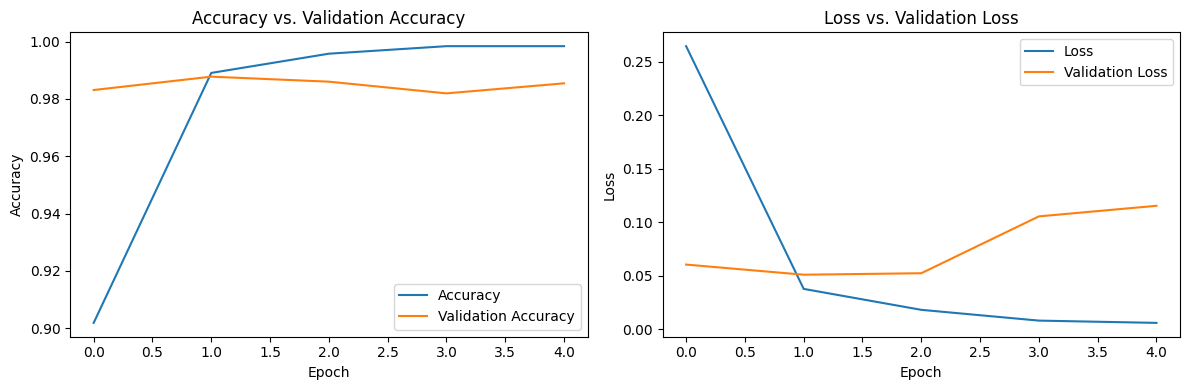

In [ ]:
accuracy = hist_gru.history['accuracy']
val_accuracy = hist_gru.history['val_accuracy']
loss = hist_gru.history['loss']
val_loss = hist_gru.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
hist_=pd.DataFrame(hist_gru.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.264518,0.901838,0.060507,0.983090
1,0.037790,0.989061,0.051039,0.987755
2,0.018228,0.995770,0.052426,0.986006
3,0.008168,0.998396,0.105525,0.981924
4,0.006041,0.998396,0.115413,0.985423


In [ ]:
loss, accuracy = model_gru.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

54/54 [==============================] - 5s 86ms/step - loss: 0.1154 - accuracy: 0.9854
Test Loss: 0.1154
Test Accuracy: 98.54%


In [ ]:
class_names = label_encoder.classes_

y_test_original = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_gru.predict(X_test), axis=1)

report = classification_report(y_test_original, y_pred, target_names=class_names)
print('Classification Report:\n', report)

54/54 [==============================] - 7s 136ms/step
Classification Report:
               precision    recall  f1-score   support

    Not-Spam       0.99      1.00      0.99      1471
        Spam       0.98      0.92      0.95       244

    accuracy                           0.99      1715
   macro avg       0.98      0.96      0.97      1715
weighted avg       0.99      0.99      0.99      1715



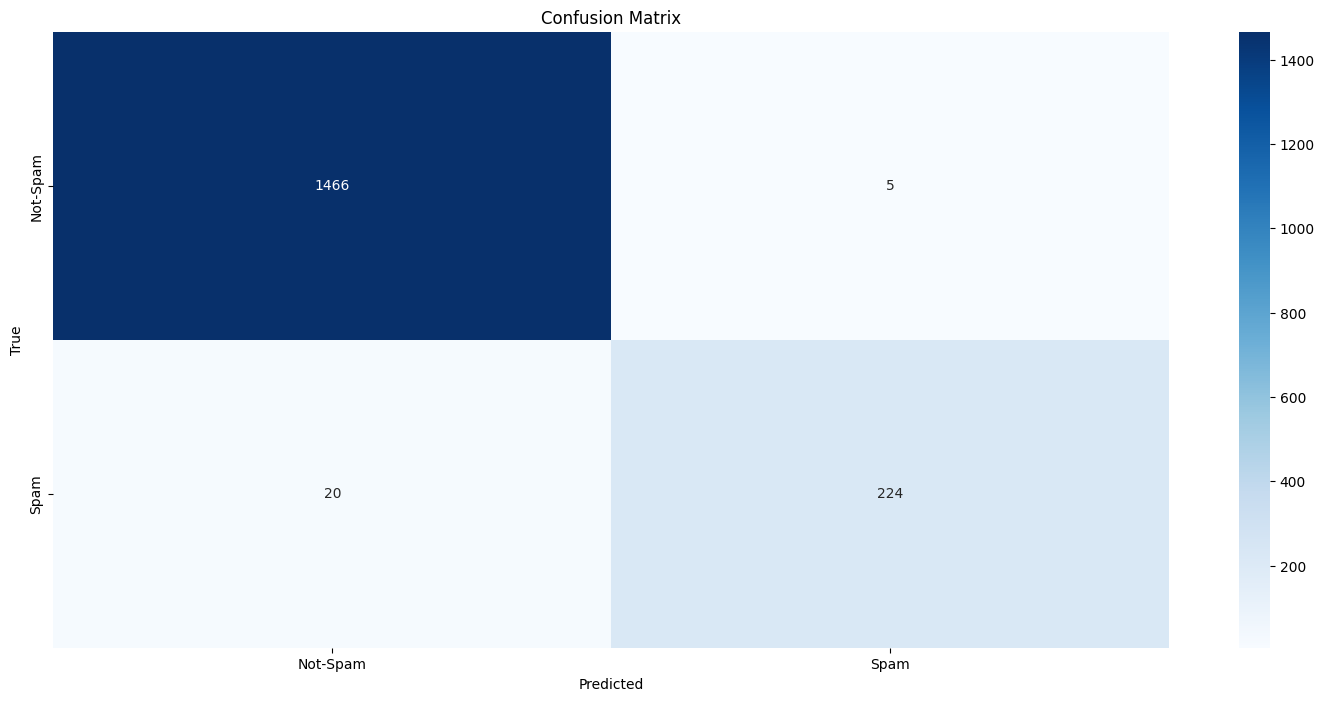

In [ ]:
conf_matrix = confusion_matrix(y_test_original, y_pred)

plt.figure(figsize=(18, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def predict_texts(texts, model, tokenizer, max_length, label_encoder):
    predictions = []

    for text in texts:
        cleaned_text = clean_text(text)
        sequences = tokenizer.texts_to_sequences([cleaned_text])
        padded_sequences = pad_sequences(sequences, maxlen=max_length)

        probabilities = model.predict(padded_sequences)[0]
        predicted_text = label_encoder.inverse_transform([probabilities.argmax()])[0]
        predictions.append((predicted_text, probabilities.max()))

    return predictions

texts = [
    "Congratulations! You've won a luxury vacation for two! 🏖️ Claim your prize now by clicking on the link below and providing your personal information. Don't miss this once-in-a-lifetime opportunity!",
    "I hope this email finds you well. Attached is the report you requested for our upcoming meeting. Please review it at your convenience, and let me know if you have any questions or need further clarification.",
    "Congratulations! You've won a free iPhone. Claim your prize now by clicking the link below!",
    "Earn $1,000 a day from home with our revolutionary work-from-home system.",
    "Reminder: Your dentist appointment is scheduled for 2:00 PM on Thursday, October 18th."
]

predicted_texts = predict_texts( texts, model_gru, tokenizer, max_length, label_encoder)

for text, (predicted_text, probability) in zip(texts, predicted_texts):
    print(f"Text: '{text}'")
    print(f"Predicted Category: {predicted_text}")
    print(f"Probability of {predicted_text}: {probability:.4f}\n")


1/1 [==============================] - 0s 59ms/step
Text: 'Congratulations! You've won a luxury vacation for two! 🏖️ Claim your prize now by clicking on the link below and providing your personal information. Don't miss this once-in-a-lifetime opportunity!'
Predicted Category: Spam
Probability of Spam: 0.7567

Text: 'I hope this email finds you well. Attached is the report you requested for our upcoming meeting. Please review it at your convenience, and let me know if you have any questions or need further clarification.'
Predicted Category: Not-Spam
Probability of Not-Spam: 1.0000

Text: 'Congratulations! You've won a free iPhone. Claim your prize now by clicking the link below!'
Predicted Category: Spam
Probability of Spam: 0.9979

Text: 'Earn $1,000 a day from home with our revolutionary work-from-home system.'
Predicted Category: Spam
Probability of Spam: 0.8851

Text: 'Reminder: Your dentist appointment is scheduled for 2:00 PM on Thursday, October 18th.'
Predicted Category: Not-S

##CNN Model Training and Evaluation

In [ ]:
model_cnn = Sequential()
model_cnn.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model_cnn.add(Conv1D(64, 2, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Conv1D(128, 2, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 120, 128)          4354432   
                                                                 
 conv1d_10 (Conv1D)          (None, 119, 64)           16448     
                                                                 
 max_pooling1d_10 (MaxPooli  (None, 59, 64)            0         
 ng1D)                                                           
                                                                 
 conv1d_11 (Conv1D)          (None, 58, 128)           16512     
                                                                 
 max_pooling1d_11 (MaxPooli  (None, 29, 128)           0         
 ng1D)                                                           
                                                                 
 flatten_10 (Flatten)        (None, 3712)            

In [ ]:
hist_cnn= model_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

Epoch 1/5
54/54 [==============================] - 11s 163ms/step - loss: 0.3392 - accuracy: 0.8539 - val_loss: 0.1338 - val_accuracy: 0.9697
Epoch 2/5
54/54 [==============================] - 10s 186ms/step - loss: 0.0686 - accuracy: 0.9818 - val_loss: 0.0538 - val_accuracy: 0.9837
Epoch 3/5
54/54 [==============================] - 8s 146ms/step - loss: 0.0222 - accuracy: 0.9950 - val_loss: 0.0801 - val_accuracy: 0.9866
Epoch 4/5
54/54 [==============================] - 10s 190ms/step - loss: 0.0087 - accuracy: 0.9980 - val_loss: 0.0853 - val_accuracy: 0.9878
Epoch 5/5
54/54 [==============================] - 7s 138ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 0.1041 - val_accuracy: 0.9854


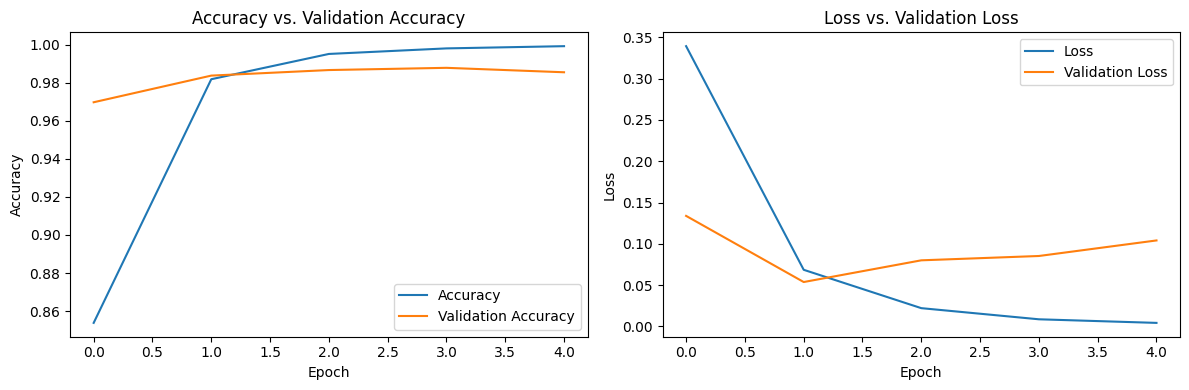

In [ ]:
accuracy = hist_cnn.history['accuracy']
val_accuracy = hist_cnn.history['val_accuracy']
loss = hist_cnn.history['loss']
val_loss = hist_cnn.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
hist_=pd.DataFrame(hist_cnn.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.339239,0.853851,0.133835,0.969679
1,0.068591,0.981768,0.053774,0.983673
2,0.022161,0.995041,0.080052,0.986589
3,0.008681,0.997958,0.085292,0.987755
4,0.004332,0.999125,0.104114,0.985423


In [ ]:
loss, accuracy = model_cnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

54/54 [==============================] - 0s 8ms/step - loss: 0.1041 - accuracy: 0.9854
Test Loss: 0.1041
Test Accuracy: 98.54%


In [ ]:
class_names = label_encoder.classes_

y_test_original = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_cnn.predict(X_test), axis=1)

report = classification_report(y_test_original, y_pred, target_names=class_names)
print('Classification Report:\n', report)

54/54 [==============================] - 0s 8ms/step
Classification Report:
               precision    recall  f1-score   support

    Not-Spam       0.99      1.00      0.99      1471
        Spam       0.97      0.92      0.95       244

    accuracy                           0.99      1715
   macro avg       0.98      0.96      0.97      1715
weighted avg       0.99      0.99      0.99      1715



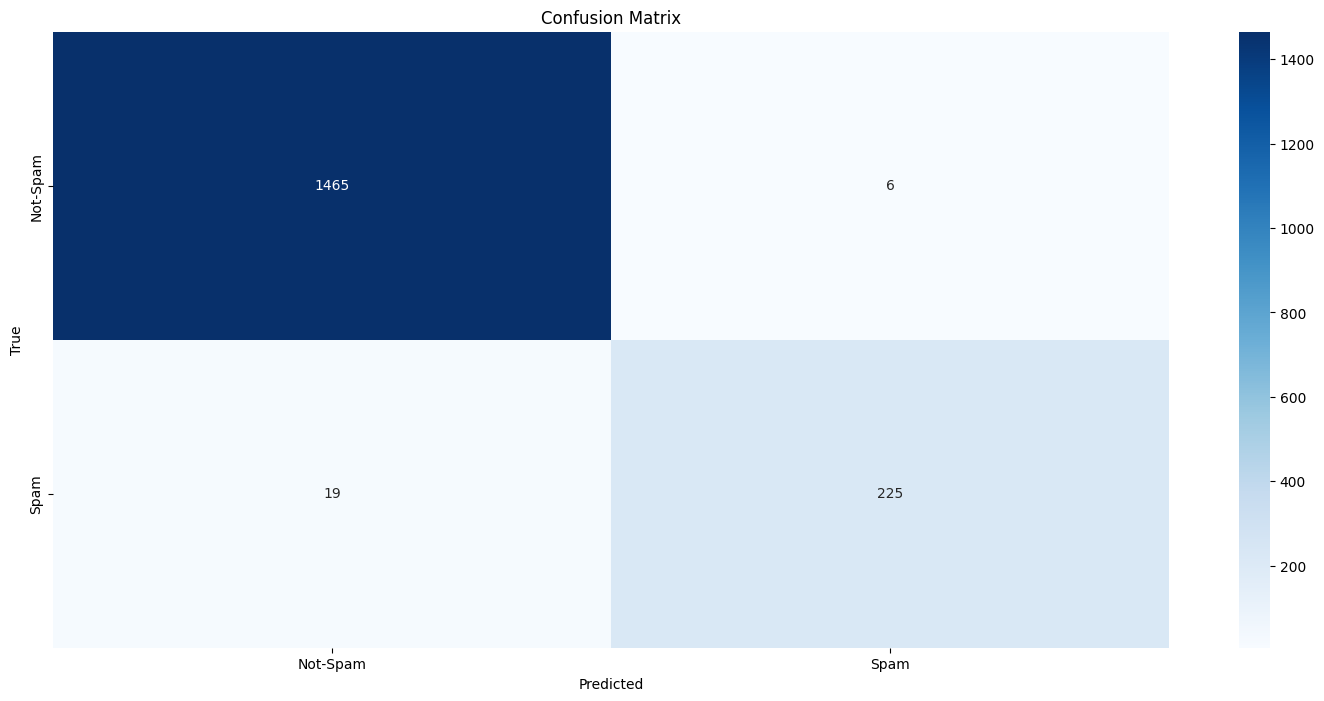

In [ ]:
conf_matrix = confusion_matrix(y_test_original, y_pred)

plt.figure(figsize=(18, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def predict_texts(texts, model, tokenizer, max_length, label_encoder):
    predictions = []

    for text in texts:
        cleaned_text = clean_text(text)
        sequences = tokenizer.texts_to_sequences([cleaned_text])
        padded_sequences = pad_sequences(sequences, maxlen=max_length)

        probabilities = model.predict(padded_sequences)[0]
        predicted_text = label_encoder.inverse_transform([probabilities.argmax()])[0]
        predictions.append((predicted_text, probabilities.max()))

    return predictions

texts = [
    "Congratulations! You've won a luxury vacation for two! 🏖️ Claim your prize now by clicking on the link below and providing your personal information. Don't miss this once-in-a-lifetime opportunity!",
    "I hope this email finds you well. Attached is the report you requested for our upcoming meeting. Please review it at your convenience, and let me know if you have any questions or need further clarification.",
    "Congratulations! You've won a free iPhone. Claim your prize now by clicking the link below!",
    "Earn $1,000 a day from home with our revolutionary work-from-home system.",
    "Reminder: Your dentist appointment is scheduled for 2:00 PM on Thursday, October 18th."
]

predicted_texts = predict_texts( texts, model_cnn, tokenizer, max_length, label_encoder)

for text, (predicted_text, probability) in zip(texts, predicted_texts):
    print(f"Text: '{text}'")
    print(f"Predicted Category: {predicted_text}")
    print(f"Probability of {predicted_text}: {probability:.4f}\n")


1/1 [==============================] - 0s 26ms/step
Text: 'Congratulations! You've won a luxury vacation for two! 🏖️ Claim your prize now by clicking on the link below and providing your personal information. Don't miss this once-in-a-lifetime opportunity!'
Predicted Category: Spam
Probability of Spam: 0.6233

Text: 'I hope this email finds you well. Attached is the report you requested for our upcoming meeting. Please review it at your convenience, and let me know if you have any questions or need further clarification.'
Predicted Category: Not-Spam
Probability of Not-Spam: 0.9999

Text: 'Congratulations! You've won a free iPhone. Claim your prize now by clicking the link below!'
Predicted Category: Spam
Probability of Spam: 0.9957

Text: 'Earn $1,000 a day from home with our revolutionary work-from-home system.'
Predicted Category: Not-Spam
Probability of Not-Spam: 0.9803

Text: 'Reminder: Your dentist appointment is scheduled for 2:00 PM on Thursday, October 18th.'
Predicted Categor

##Hybrid Model Training and Evaluation

In [ ]:
model_hb = Sequential()
model_hb.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_length))
model_hb.add(Conv1D(128, 2, activation='relu'))
model_hb.add(MaxPooling1D(2))
model_hb.add(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model_hb.add(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model_hb.add(LSTM(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
model_hb.add(Flatten())
model_hb.add(Dense(128, activation='relu'))
model_hb.add(Dropout(0.3))
model_hb.add(Dense(len(label_encoder.classes_), activation='softmax'))

model_hb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_hb.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 120, 128)          4354432   
                                                                 
 conv1d_12 (Conv1D)          (None, 119, 128)          32896     
                                                                 
 max_pooling1d_12 (MaxPooli  (None, 59, 128)           0         
 ng1D)                                                           
                                                                 
 lstm_9 (LSTM)               (None, 59, 128)           131584    
                                                                 
 lstm_10 (LSTM)              (None, 59, 64)            49408     
                                                                 
 lstm_11 (LSTM)              (None, 59, 32)            12416     
                                                     

In [ ]:
hist_hb= model_hb.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=128)

Epoch 1/5
54/54 [==============================] - 114s 2s/step - loss: 0.3570 - accuracy: 0.8772 - val_loss: 0.0986 - val_accuracy: 0.9697
Epoch 2/5
54/54 [==============================] - 61s 1s/step - loss: 0.0677 - accuracy: 0.9826 - val_loss: 0.0634 - val_accuracy: 0.9831
Epoch 3/5
54/54 [==============================] - 66s 1s/step - loss: 0.0250 - accuracy: 0.9940 - val_loss: 0.0749 - val_accuracy: 0.9854
Epoch 4/5
54/54 [==============================] - 66s 1s/step - loss: 0.0118 - accuracy: 0.9972 - val_loss: 0.0848 - val_accuracy: 0.9848
Epoch 5/5
54/54 [==============================] - 65s 1s/step - loss: 0.0083 - accuracy: 0.9988 - val_loss: 0.0951 - val_accuracy: 0.9854


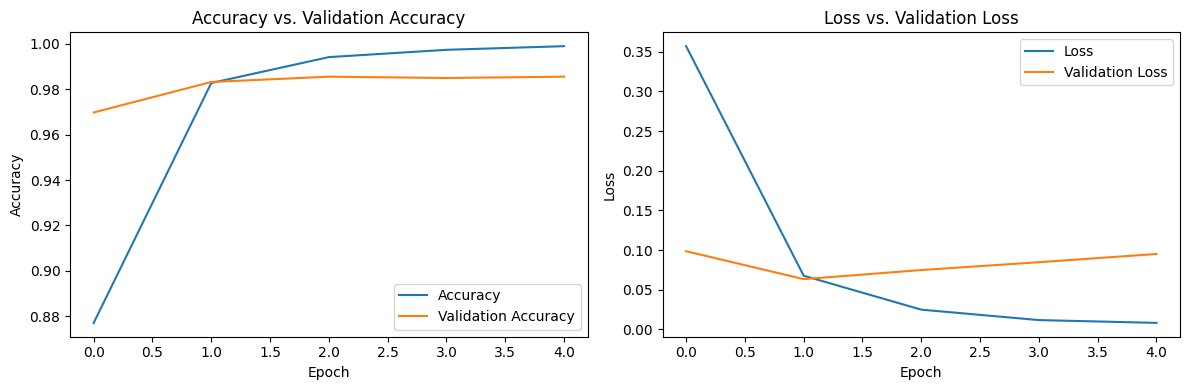

In [ ]:
accuracy = hist_hb.history['accuracy']
val_accuracy = hist_hb.history['val_accuracy']
loss = hist_hb.history['loss']
val_loss = hist_hb.history['val_loss']

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
hist_=pd.DataFrame(hist_hb.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.357030,0.877188,0.098610,0.969679
1,0.067717,0.982643,0.063441,0.983090
2,0.024970,0.994020,0.074894,0.985423
3,0.011824,0.997229,0.084773,0.984840
4,0.008294,0.998833,0.095134,0.985423


In [ ]:
class_names = label_encoder.classes_

y_test_original = np.argmax(y_test, axis=1)
y_pred = np.argmax(model_hb.predict(X_test), axis=1)

report = classification_report(y_test_original, y_pred, target_names=class_names)
print('Classification Report:\n', report)

54/54 [==============================] - 4s 57ms/step
Classification Report:
               precision    recall  f1-score   support

    Not-Spam       0.99      1.00      0.99      1471
        Spam       0.97      0.92      0.95       244

    accuracy                           0.99      1715
   macro avg       0.98      0.96      0.97      1715
weighted avg       0.99      0.99      0.99      1715



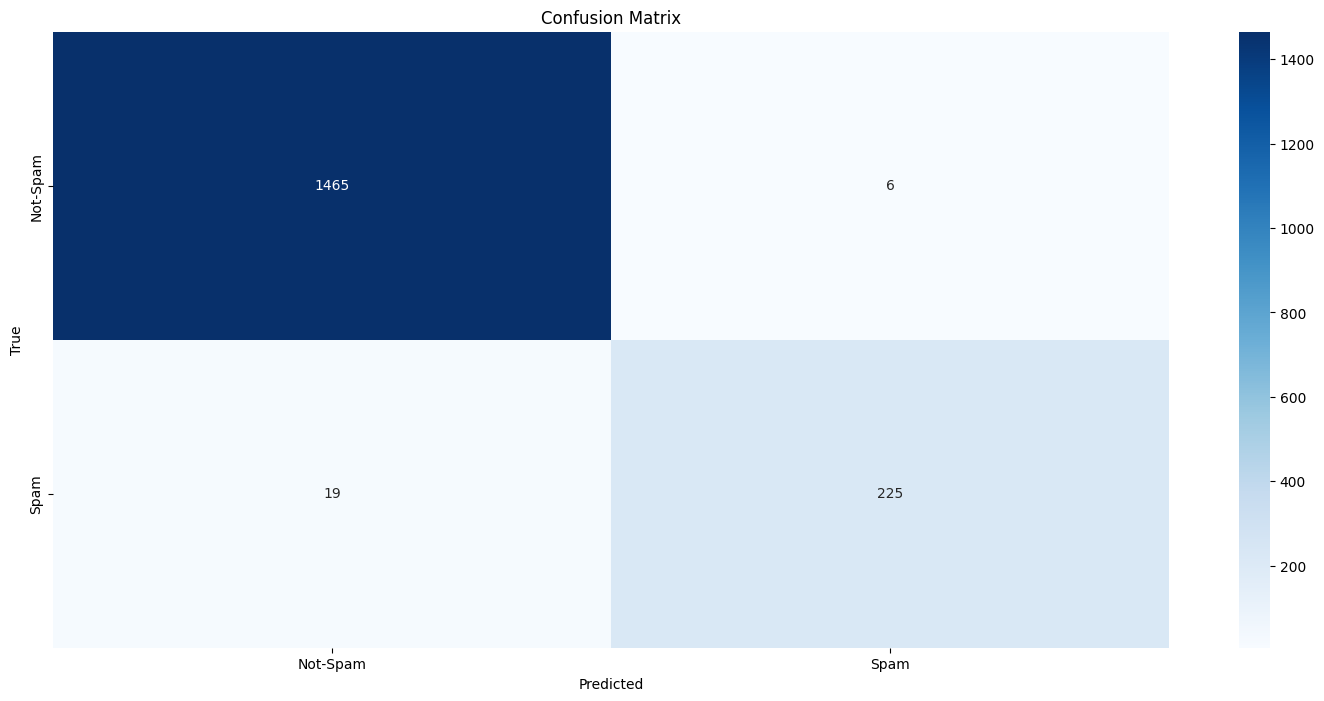

In [ ]:
conf_matrix = confusion_matrix(y_test_original, y_pred)

plt.figure(figsize=(18, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def predict_texts(texts, model, tokenizer, max_length, label_encoder):
    predictions = []

    for text in texts:
        cleaned_text = clean_text(text)
        sequences = tokenizer.texts_to_sequences([cleaned_text])
        padded_sequences = pad_sequences(sequences, maxlen=max_length)

        probabilities = model.predict(padded_sequences)[0]
        predicted_text = label_encoder.inverse_transform([probabilities.argmax()])[0]
        predictions.append((predicted_text, probabilities.max()))

    return predictions

texts = [
    "Congratulations! You've won a luxury vacation for two! 🏖️ Claim your prize now by clicking on the link below and providing your personal information. Don't miss this once-in-a-lifetime opportunity!",
    "I hope this email finds you well. Attached is the report you requested for our upcoming meeting. Please review it at your convenience, and let me know if you have any questions or need further clarification.",
    "Congratulations! You've won a free iPhone. Claim your prize now by clicking the link below!",
    "Earn $1,000 a day from home with our revolutionary work-from-home system.",
    "Reminder: Your dentist appointment is scheduled for 2:00 PM on Thursday, October 18th."
]

predicted_texts = predict_texts( texts, model_hb, tokenizer, max_length, label_encoder)

for text, (predicted_text, probability) in zip(texts, predicted_texts):
    print(f"Text: '{text}'")
    print(f"Predicted Category: {predicted_text}")
    print(f"Probability of {predicted_text}: {probability:.4f}\n")


1/1 [==============================] - 0s 48ms/step
Text: 'Congratulations! You've won a luxury vacation for two! 🏖️ Claim your prize now by clicking on the link below and providing your personal information. Don't miss this once-in-a-lifetime opportunity!'
Predicted Category: Spam
Probability of Spam: 0.9991

Text: 'I hope this email finds you well. Attached is the report you requested for our upcoming meeting. Please review it at your convenience, and let me know if you have any questions or need further clarification.'
Predicted Category: Not-Spam
Probability of Not-Spam: 0.9992

Text: 'Congratulations! You've won a free iPhone. Claim your prize now by clicking the link below!'
Predicted Category: Spam
Probability of Spam: 0.9962

Text: 'Earn $1,000 a day from home with our revolutionary work-from-home system.'
Predicted Category: Spam
Probability of Spam: 0.9948

Text: 'Reminder: Your dentist appointment is scheduled for 2:00 PM on Thursday, October 18th.'
Predicted Category: Not-S

##Bert Model for Spam Prediction

###Text Data Splitting and Preprocessing

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Spam'], test_size=0.33, random_state=42)

In [ ]:
X_train = X_train.tolist()
X_test = X_test.tolist()
y_train = y_train.tolist()
y_test = y_test.tolist()

In [ ]:
class_names = ['Spam', 'Not-Spam']

In [ ]:
(x_train,y_train), (x_val,y_val), preproc = text.texts_from_array(x_train=X_train, y_train=y_train,
                                                                       x_test=X_test, y_test=y_test,
                                                                       class_names=class_names,
                                                                       preprocess_mode='bert',
                                                                       maxlen=512,
                                                                       max_features=20000)

downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


/usr/local/lib/python3.9/dist-packages/ktrain/utils.py:744: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  warnings.warn(


task: text classification


###BERT-Based Text Classification Model Training and Evaluation

In [ ]:
model = text.text_classifier('bert', train_data=(x_train,y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 512


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


done.


In [ ]:
learner = ktrain.get_learner(model, train_data=(x_train,y_train),
                             val_data=(x_val,y_val),
                             batch_size=6)

In [ ]:
learner.fit_onecycle(2e-5, 3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
957/957 [==============================] - 918s 940ms/step - loss: 0.1116 - accuracy: 0.9620 - val_loss: 0.0297 - val_accuracy: 0.9919
Epoch 2/3
957/957 [==============================] - 897s 937ms/step - loss: 0.0307 - accuracy: 0.9909 - val_loss: 0.0388 - val_accuracy: 0.9883
Epoch 3/3
957/957 [==============================] - 878s 918ms/step - loss: 0.0067 - accuracy: 0.9979 - val_loss: 0.0273 - val_accuracy: 0.9943


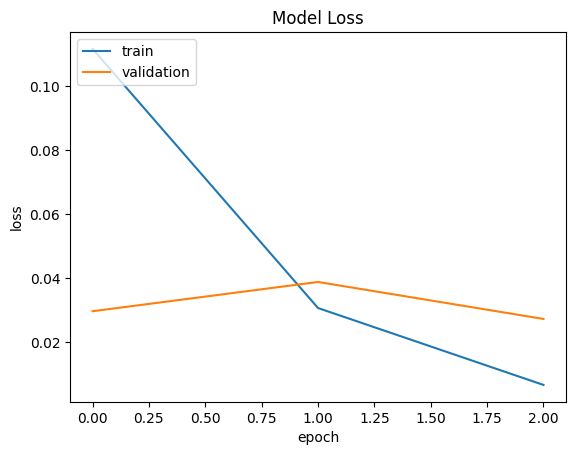

In [ ]:
learner.plot()

In [ ]:
learner.validate(val_data=(x_val,y_val), class_names=class_names)

89/89 [==============================] - 124s 1s/step
              precision    recall  f1-score   support

        Spam       1.00      1.00      1.00      2400
    Not-Spam       0.99      0.98      0.98       429

    accuracy                           0.99      2829
   macro avg       0.99      0.99      0.99      2829
weighted avg       0.99      0.99      0.99      2829



array([[2394,    6],
       [  10,  419]])

In [ ]:
predictor = ktrain.get_predictor(learner.model, preproc)
predictor.get_classes()

['Not-Spam', 'Spam']

In [ ]:
message = 'get 2 free entries'
prediction = predictor.predict(message)
print('predicted: {}'.format(prediction))

predicted: Spam


###Save Bert Model

In [ ]:
predictor.save("/content/drive/MyDrive/Colab_Notebooks/DL Model/Spam Message Detector/bert_model_spam")

###Load Saved Model

In [ ]:
predictor1 = ktrain.load_predictor('/content/drive/MyDrive/Colab_Notebooks/DL Model/Spam Message Detector/bert_model_spam')

/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
data = " get 2 free entries"
predictor1.predict(data)

'Spam'